# Lab Exercise 6: FSK-MSK

The purpose of this lab exercise is to simulate and analyze Frequency Shift Keying (FSK) and Minimum Shift Keying (MSK) systems. Students will compare coherent and non-coherent demodulation, calculate bit error rates, and examine the spectral properties of these modulation schemes. The exercise also includes an optional task to compare MSK and QPSK systems in terms of bit error rate and bandwidth.


## Setup


```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>


#### Importing packages we will need later in Python


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from scipy.signal import welch, upfirdn, firwin
import scipy.special
from scipy.special import erfc
import math
import scipy.signal as signal
from math import log, log2, sqrt
import ipywidgets as widgets
from ipywidgets import IntSlider, IntRangeSlider, FloatSlider, interactive, Layout, Dropdown, IntText, HBox, VBox, Output
from IPython.display import display, clear_output
from commpy.channels import awgn
import time
print("Libraries added successfully!")

Libraries added successfully!


## Part 1: Useful Code

`````{dropdown} Code 6.1
````{tab} Python
```python
def fsk_errors(bps, Nsymb, ns, EbNo):
    # Input parameters
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "coherent" distance (BR)
    f = fc + (BR/2) * (np.arange(1, M + 1) - (M + 1) / 2)

    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = y.reshape((Nsymb, bps))

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))
    s = np.concatenate(s)

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    xr = []
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        smi = []
        for fi in f:
            si = np.sin(2 * np.pi * fi * tk)
            smi.append(np.sum(sk * si))
        j = np.argmax(smi)
        xr.append([int(bit) for bit in bin(j)[2:].zfill(bps)])
    xr = np.array(xr).reshape((Nsymb, bps))

    # count errors
    errors = np.sum(x != xr)
    return errors
```
````

````{tab} Matlab
```matlab
function errors=fsk_errors(bps,Nsymb,ns,EbNo)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%% Input parameters
% bps: bits per symbol, Nsymb: numb of simulated symbols
% ns: number of samples per symbol (oversampling)
% EbNo: normalized signal-to-noise ratio, in db
M=2^bps; % number of different symbols
BR=1; % Baud Rate
fc=2*M*BR; % RF frequency
%% Derived parameters
nb=bps*Nsymb; % number of simulated data bits
T=1/BR; % one symbol period
Ts=T/ns; % oversampling period
% M frequencies in "coherent" distance (BR)
f=fc+(BR/2)*((1:M)-(M+1)/2);
% Calculate the maximum frequency
fmax = max(f);
% Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax;
ns = ceil(Fs / BR) + 10;
% Recalculate the oversampling period
Ts = T / ns;
% awgn channel
SNR=EbNo+10*log10(bps)-10*log10(ns/2); % in db
% input data bits
y = randi([0 1], nb, 1); % Ensure integer dimensions
x = reshape(y, bps, [])';
t=[0:T:length(x(:,1))*T]'; % time vector on the T grid
tks=[0:Ts:T-Ts]';
%% FSK signal
s=[];
A=sqrt(2/T/ns);
for k=1:length(x(:,1))
    fk=f(bi2de(x(k,:))+1);
    tk=(k-1)*T+tks;
    s=[s; sin(2*pi*fk*tk)];
end
% add noise to the FSK (passband) signal
s=awgn(s,SNR, 'measured');
%% FSK receiver
% coherent demodulation
th=0;
xr=[];
for k=1:length(s)/ns
    tk=(k-1)*T+tks;
    sk=s((k-1)*ns+1:k*ns);
    smi=[];
    for i=1:M
        si=sin(2*pi*f(i)*tk);
        smi(i)=sum(sk.*si);
    end
    [m,j]=max(smi);
    xr=[xr;de2bi(j-1,bps)];
end
% count errors
err=not(x==xr);
errors=sum(sum(err));
end
```
````
`````


## Part 2: Code testing
Run code 6.1 of the notes (step-by-step, not by calling the function) for M=16 and
confirm the obtained number of errors for two different values of the normalized
signal-to-noise ratio


In [2]:
# Loading animation
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    """
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>
        </div>
        """
loader_html3 = widgets.HTML(
  value=loading
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"
)

# Parameters
bps = 4  # bits per symbol
Nsymb = 1000  # number of simulated symbols
ns = 80  # number of samples per symbol (oversampling)

# Derived parameters
M = 2 ** bps  # number of different symbols
BR = 1  # Baud Rate
fc = 2 * M * BR  # RF frequency

# Derived parameters
nb = bps * Nsymb  # number of simulated data bits
T = 1 / BR  # one symbol period
Ts = T / ns  # oversampling period

# M frequencies in "coherent" distance (BR)
f = fc + (BR/2) * (np.arange(1, M + 1) - (M + 1) / 2)

# Calculate the maximum frequency
fmax = np.max(f)

# Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax
ns = int(np.ceil(Fs / BR)) + 10

# Recalculate the oversampling period
Ts = T / ns

# input data bits
y = np.random.randint(0, 2, nb)
x = y.reshape((Nsymb, bps))

t = np.arange(0, len(x) * T, T)  # time vector on the T grid
tks = np.arange(0, T, Ts)  # oversampling time vector

# FSK signal
s = []
A = np.sqrt(2 / T / ns)
for k in range(len(x)):
    fk = f[int(''.join(map(str, x[k])), 2)]
    tk = (k * T) + tks
    s.append(np.sin(2 * np.pi * fk * tk))
s = np.concatenate(s)


def calculate_errors(EbNo_range):
    # Start timer
    loader_html3.value = loading
    start_time = time.time()

    clear_output(wait=True)
    EbNo_values = list(range(EbNo_range[0], EbNo_range[1] + 1))
    errors_list = []
    for EbNo in EbNo_values:
        # Calculate SNR
        SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

        # add noise to the FSK (passband) signal
        noisy_signal = awgn(s, SNR)

        # FSK receiver
        xr = []
        for k in range(len(noisy_signal) // ns):
            tk = (k * T) + tks
            sk = noisy_signal[k * ns:(k + 1) * ns]
            smi = []
            for fi in f:
                si = np.sin(2 * np.pi * fi * tk)
                smi.append(np.sum(sk * si))
            j = np.argmax(smi)
            xr.append([int(bit) for bit in bin(j)[2:].zfill(bps)])
        xr = np.array(xr).reshape((Nsymb, bps))

        # count errors
        errors = np.sum(x != xr)
        errors_list.append(errors)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(EbNo_values, errors_list, marker='o', linestyle='-', markersize=8)
    plt.xlabel('Eb/No (dB)')
    plt.ylabel('Number of Errors')
    plt.title('Number of Errors vs. Eb/No')
    plt.grid(True)
    plt.show()
    
    # Show elapsed time
    elapsed_time = time.time() - start_time
    timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    loader_html3.value = done

# Create the range slider widget
EbNo_slider = IntRangeSlider(
    value=[0, 20],
    min=0,
    max=20,
    step=1,
    description='EbNo (dB):',
    continuous_update=False,
    layout=Layout(width='99%')
)

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create interactive widget
interactive_plot = interactive(calculate_errors, EbNo_range=EbNo_slider)

input_widgets = VBox([EbNo_slider], layout=Layout(flex='1 1 auto', width='auto'))
plot_output = interactive_plot.children[-1]  # The output plot

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create a VBox that includes both the input widgets and the loading animation
inputs_and_loader = HBox([input_widgets, loader_timer_box], layout=Layout(align_items='center'))

# Create an HBox to hold everything in a horizontal layout
ui = VBox([inputs_and_loader, plot_output])

# Display the UI components
clear_output(wait=True)  # Clear the previous output
display(ui)

## Part 3: Non-coherent demodulation

Complete the above code (code 6.1) in order to also simulate the non-coherent FSK

```{tip}
Add random phase to the received signal, before demodulation.
```


`````{dropdown} Code 6.2
````{tab} Python
```python
def fsk_errors_non_coh(bps, Nsymb, ns, EbNo):
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period
    f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)  # M frequencies

    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)  # Ensure integer dimensions
    x = y.reshape((-1, bps))
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = np.array([])
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int("".join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s = np.concatenate((s, np.sin(2 * np.pi * fk * tk)))

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    # Non-coherent demodulation
    xr = np.array([])
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        sm = []
        for i in range(M):
            si = np.sin(2 * np.pi * (f[i] * tk))
            sq = np.cos(2 * np.pi * (f[i] * tk))
            smi = np.sum(sk * si)
            smq = np.sum(sk * sq)
            sm.append(np.sqrt(smi ** 2 + smq ** 2))
        j = np.argmax(sm)
        xr = np.concatenate((xr, np.array(list(np.binary_repr(j, width=bps)), dtype=int)))

    # count errors
    x_reshaped = x.reshape(-1)
    xr_reshaped = xr.reshape(-1)
    err = np.not_equal(x_reshaped, xr_reshaped)
    errors = np.sum(err)
    return errors
```
````

````{tab} Matlab
```matlab
function errors = fsk_errors_non_coh(bps, Nsymb, ns, EbNo)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %% Input parameters
    % bps: bits per symbol, Nsymb: number of simulated symbols
    % ns: number of samples per symbol (oversampling)
    % EbNo: normalized signal-to-noise ratio, in dB
    M = 2^bps; % number of different symbols
    BR = 1; % Baud Rate
    fc = 2 * M * BR; % RF frequency
    
    %% Derived parameters
    nb = bps * Nsymb; % number of simulated data bits
    T = 1 / BR; % one symbol period
    Ts = T / ns; % oversampling period
    % M frequencies in "non-coherent" distance (BR)
    f = fc + BR * ((1:M) - (M + 1) / 2);
    % Calculate the maximum frequency
    fmax = max(f);

    % Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax;
    ns = ceil(Fs / BR) + 10;

    % Recalculate the oversampling period
    Ts = T / ns;
    % AWGN channel
    SNR = EbNo + 10 * log10(bps) - 10 * log10(ns / 2); % in dB
    % input data bits
    y = randi([0 1], nb, 1); % Ensure integer dimensions
    x = reshape(y, bps, [])';
    t = [0:T:length(x(:,1)) * T]'; % time vector on the T grid
    tks = [0:Ts:T-Ts]';
    
    %% FSK signal
    s = [];
    A = sqrt(2 / T / ns);
    for k = 1:length(x(:,1))
        fk = f(bi2de(x(k,:)) + 1);
        tk = (k - 1) * T + tks;
        s = [s; sin(2 * pi * fk * tk)];
    end
    
    % add noise to the FSK (passband) signal
    s = awgn(s, SNR, 'measured');
    
    %% FSK receiver
    % Non-coherent demodulation
    th = 0;
    xr = [];
    for k = 1:length(s) / ns
        tk = (k - 1) * T + tks;
        sk = s((k - 1) * ns + 1:k * ns);
        sm = [];
        for i = 1:M
            si = sin(2 * pi * (f(i) * tk + th));
            sq = cos(2 * pi * (f(i) * tk + th));
            smi = sum(sk .* si);
            smq = sum(sk .* sq);
            sm(i) = sqrt(smi^2 + smq^2);
        end
        [m, j] = max(sm);
        xr = [xr; de2bi(j - 1, bps)];
    end
    
    % count errors
    err = not(x == xr);
    errors = sum(sum(err));
end
```
````
`````


## Part 3:

Use your new function to simulate a 16-FSK system and plot the Pb vs Eb/No curves
for coherent and non-coherent demodulation (theoretical and from simulation).


In [3]:
# Loading animation
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    """
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>
        </div>
        """
loader_html3 = widgets.HTML(
  value=loading
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"
)


def fsk_errors(bps, Nsymb, ns, EbNo):
    # Input parameters
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # M frequencies in "coherent" distance (BR)
    f = fc + (BR/2) * (np.arange(1, M + 1) - (M + 1) / 2)

    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = y.reshape((Nsymb, bps))

    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal
    s = []
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))
    s = np.concatenate(s)

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    xr = []
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        smi = []
        for fi in f:
            si = np.sin(2 * np.pi * fi * tk)
            smi.append(np.sum(sk * si))
        j = np.argmax(smi)
        xr.append([int(bit) for bit in bin(j)[2:].zfill(bps)])
    xr = np.array(xr).reshape((Nsymb, bps))

    # count errors
    errors = np.sum(x != xr)
    return errors


def fsk_errors_non_coh(bps, Nsymb, ns, EbNo):
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    fc = 2 * M * BR  # RF frequency

    # Derived parameters
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period
    f = fc + BR * (np.arange(1, M + 1) - (M + 1) / 2)  # M frequencies

    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # AWGN channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)  # Ensure integer dimensions
    x = y.reshape((-1, bps))
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)

    # FSK signal
    s = np.array([])
    A = np.sqrt(2 / T / ns)
    for k in range(len(x)):
        fk = f[int("".join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s = np.concatenate((s, np.sin(2 * np.pi * fk * tk)))

    # add noise to the FSK (passband) signal
    s = awgn(s, SNR)

    # FSK receiver
    # Non-coherent demodulation
    xr = np.array([])
    for k in range(len(s) // ns):
        tk = (k * T) + tks
        sk = s[k * ns:(k + 1) * ns]
        sm = []
        for i in range(M):
            si = np.sin(2 * np.pi * (f[i] * tk))
            sq = np.cos(2 * np.pi * (f[i] * tk))
            smi = np.sum(sk * si)
            smq = np.sum(sk * sq)
            sm.append(np.sqrt(smi ** 2 + smq ** 2))
        j = np.argmax(sm)
        xr = np.concatenate((xr, np.array(list(np.binary_repr(j, width=bps)), dtype=int)))

    # count errors
    x_reshaped = x.reshape(-1)
    xr_reshaped = xr.reshape(-1)
    err = np.not_equal(x_reshaped, xr_reshaped)
    errors = np.sum(err)
    return errors


# BER simulation function
def simulate_ber(bps, Nsymb, ns, EbNo_values, coherent=True):
    ber = []
    for EbNo in EbNo_values:
        errors = 0
        for _ in range(1):  # averaging over 10 iterations
            if coherent:
                errors += fsk_errors(bps, Nsymb, ns, EbNo)
            else:
                errors += fsk_errors_non_coh(bps, Nsymb, ns, EbNo)
        ber.append(errors / (Nsymb * bps * 10))
    return ber


# Define the BER values directly inside the functions
def theoretical_ber_coh(EbNo, M):
    if M == 2:
        return np.array([0.15866, 0.13093, 0.10403, 0.078896, 0.056495,
    0.037679, 0.023007, 0.012587, 0.0060044, 0.0024133,
    0.0007827, 0.00019399, 3.4303e-05, 3.9692e-06, 2.6951e-07])
    elif M == 4:
        return np.array([0.11814, 0.087789, 0.060786, 0.038512, 0.021824, 
    0.010751, 0.0044428, 0.0014733, 0.00037102, 6.6229e-05, 
    7.6892e-06, 5.2118e-07, 1.7997e-08, 2.6653e-10, 1.362e-12])
    elif M == 8:
        return np.array([0.10227, 0.067834, 0.041318, 0.022024, 0.0099156, 
    0.0036087, 0.0010058, 0.00020086, 2.6486e-05, 2.0836e-06, 
    8.6119e-08, 1.5924e-09, 1.074e-11, 2.0391e-14, 7.8524e-18])
    elif M == 16:
        return np.array([0.089859, 0.055663, 0.029957, 0.013469, 0.004819,
    0.001293, 0.00024205, 2.897e-05, 1.9921e-06, 6.8928e-08,
    1.0145e-09, 5.1257e-12, 6.7629e-15, 1.6453e-18, 4.6157e-23])
    elif M == 32:
        return np.array([0.082719, 0.047105, 0.022469, 0.0085348, 0.0024266,
    0.00047917, 6.0083e-05, 4.2975e-06, 1.5388e-07, 2.3425e-09,
    1.2294e-11, 1.6992e-14, 4.3826e-18, 1.3266e-22, 2.1688e-28])
    else:
        raise ValueError("Unsupported value of M for coherent case")


def theoretical_ber_non_coh(EbNo, M):
    if M == 2:
        return np.array([0.30327, 0.26644, 0.22637, 0.18438, 0.1424, 0.10287, 
    0.068311, 0.0408, 0.021324, 0.0094212, 0.003369, 
    0.0009231, 0.00018089, 2.3244e-05, 1.7558e-06])
    elif M == 4:
        return np.array([0.22934, 0.18475, 0.13987, 0.097719, 0.061557, 
    0.033946, 0.01579, 0.0059139, 0.0016837, 0.00033939, 
    4.4371e-05, 3.3753e-06, 1.3045e-07, 2.1593e-09, 1.233e-11])
    elif M == 8:
        return np.array([0.19472, 0.14559, 0.099187, 0.059806, 0.030757, 
    0.012878, 0.0041438, 0.00095467, 0.00014449, 1.2945e-05, 
    6.0428e-07, 1.2541e-08, 9.4638e-11, 2.0092e-13, 8.6607e-17])
    elif M == 16:
        return np.array([0.17469, 0.12169, 0.074737, 0.038861, 0.01625, 
    0.005127, 0.0011288, 0.00015786, 1.2538e-05, 4.943e-07, 
    8.2001e-09, 4.6432e-11, 6.8517e-14, 1.8682e-17, 6.0826e-22])
    elif M == 32:
        return np.array([0.16103, 0.10471, 0.058014, 0.025984, 0.0088058, 
    0.0020817, 0.00031127, 2.6219e-05, 1.0859e-06, 1.8789e-08, 
    1.1086e-10, 1.7154e-13, 4.9582e-17, 1.737e-21, 4.2722e-27])
    else:
        raise ValueError("Unsupported value of M for non-coherent case")


# Function to update the plot
def update_plot(bps):
    # Start the timer
    loader_html3.value = loading
    start_time = time.time()

    Nsymb = 5000  # number of symbols
    ns = 100  # oversampling factor
    EbNo_dB_sim = np.arange(0, 10, 2)  # Eb/No values in dB for simulation
    EbNo_dB_theory = np.arange(0, 15, 1)  # Eb/No values in dB for theoretical
    
    EbNo_sim = 10 ** (EbNo_dB_sim / 10)  # convert dB to linear for simulation
    EbNo_theory = 10 ** (EbNo_dB_theory / 10)  # convert dB to linear for theoretical
    M = 2 ** bps  # M-ary FSK

    # Simulate BER
    ber_coh_sim = simulate_ber(bps, Nsymb, ns, EbNo_dB_sim, coherent=True)
    ber_non_coh_sim = simulate_ber(bps, Nsymb, ns, EbNo_dB_sim, coherent=False)
    
    # Theoretical BER
    ber_coh_theory = theoretical_ber_coh(EbNo_theory, M)
    ber_non_coh_theory = theoretical_ber_non_coh(EbNo_theory, M)

    # Show plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(EbNo_dB_sim, ber_coh_sim, 'o', label=f'Simulated Coherent {M}-FSK')
    plt.semilogy(EbNo_dB_sim, ber_non_coh_sim, 's', label=f'Simulated Non-Coherent {M}-FSK')
    plt.semilogy(EbNo_dB_theory, ber_coh_theory, label=f'(Upper Limit) Theoretical Coherent {M}-FSK')
    plt.semilogy(EbNo_dB_theory, ber_non_coh_theory, label=f'(Upper Limit) Theoretical Non-Coherent {M}-FSK')

    plt.title(f'BER vs. Eb/No for {M}-FSK Systems')
    plt.xlabel('Eb/No (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

    # Show elapsed time
    elapsed_time = time.time() - start_time
    timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    loader_html3.value = done

# Dropdown for M-FSK selection
bps_dropdown = Dropdown(
    options=[('2-FSK', 1), ('4-FSK', 2), ('8-FSK', 3), ('16-FSK', 4), ('32-FSK', 5)],
    value=2,
    description='M-FSK:',
)

# Interactive plot
interactive_plot = interactive(update_plot, bps=bps_dropdown)

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

input_widgets = VBox([bps_dropdown], layout=Layout(width='auto'))
plot_output = interactive_plot.children[-1]  # The output plot

# Create a VBox that includes both the input widgets and the loading animation
inputs_and_loader = HBox([input_widgets, loader_timer_box], layout=Layout(align_items='center'))

# Create an HBox to hold everything in a horizontal layout
ui = VBox([inputs_and_loader, plot_output])

# Display the UI components
clear_output(wait=True)  # Clear the previous output
display(ui)

## Part 4:

Plot the spectrum of the bandpass signal of question 3.


`````{dropdown} Solution
````{tab} Python - Coherent
```python
# Input parameters
bps = 4
Nsymb = 10000
EbNo = 8

# Derived parameters
M = 2 ** bps  # number of different symbols
BR = 1  # Baud Rate
fc = 2 * M * BR  # RF frequency
ns = 80  # samples per symbol
nb = bps * Nsymb  # number of simulated data bits
f = fc + (BR / 2) * ((np.arange(1, M + 1)) - (M + 1) / 2)

# Calculate the maximum frequency
fmax = np.max(f)

# Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax
ns = int(np.ceil(Fs / BR)) + 10

# Recalculate the oversampling period
Ts = T / ns

# awgn channel
SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

# input data bits
y = np.random.randint(0, 2, nb)
x = np.reshape(y, (len(y) // bps, bps))

# time vectors
t = np.arange(0, len(x) * T, T)  # time vector on the T grid
tks = np.arange(0, T, Ts)  # oversampling time vector

# FSK signal generation
s = []
A = np.sqrt(2 / T / ns)

for k in range(len(x)):
    fk = f[int(''.join(map(str, x[k])), 2)]
    tk = (k * T) + tks
    s.append(np.sin(2 * np.pi * fk * tk))

s = np.concatenate(s)

# Plotting power spectral density with higher resolution
frequencies, Pxx = welch(s, fs=ns*BR, nperseg=50000)
plt.figure()
plt.semilogy(frequencies, Pxx, linewidth=0.5)
plt.title("FSK Coherent")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.grid(True)
plt.show()
```
````

````{tab} Matlab - Coherent
```matlab
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%% Input parameters
clear all;
bps=4;Nsymb=10000;EbNo=8;
% bps: bits per symbol, Nsymb: numb of simulated symbols
% ns: number of samples per symbol (oversampling)
% EbNo: normalized signal-to-noise ratio, in db
M=2^bps; % number of different symbols
BR=1; % Baud Rate
fc=2*M*BR; % RF frequency
ns=80; % ns samples per symbol ώστε Fs=ns*Fd >=2*fmax
%% Derived parameters
nb=bps*Nsymb; % number of simulated data bits
% M frequencies in coherent distance (BR/2)
f=fc+(BR/2)*((1:M)-(M+1)/2);
fmax = max(f); % Calculate the maximum frequency
% Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax;
ns = ceil(Fs / BR) + 10;
% Recalculate the oversampling period
Ts = T / ns;
% awgn channel
SNR=EbNo+10*log10(bps)-10*log10(ns/2); % in db
% input data bits
y=randi([0 1],1,nb);%
x=reshape(y,bps,length(y)/bps)';
t=[0:T:length(x(:,1))*T]'; % time vector on the T grid
tks=[0:Ts:T-Ts]';
%% FSK signal
s=[];
A=sqrt(2/T/ns);
%th=pi*rand(M,1);
for k=1:length(x(:,1))
fk=f(bi2de(x(k,:))+1);
tk=(k-1)*T+tks;
s=[s; sin(2*pi*fk*tk)]; % th(bi2de(x(k,:))+1))];
end

figure;pwelch(s,[],[],[],ns*BR);title("fsk coherent");
```
````

````{tab} Python - Non-coherent
```python
# Input parameters
bps = 4
Nsymb = 10000
EbNo = 8

# Derived parameters
M = 2 ** bps  # number of different symbols
BR = 1  # Baud Rate
fc = 2 * M * BR  # RF frequency
ns = 90  # samples per symbol
nb = bps * Nsymb  # number of simulated data bits
T = 1 / BR  # one symbol period
Ts = T / ns  # oversampling period

# Frequencies in "non-coherent" distance
f = fc + BR * ((np.arange(1, M + 1)) - (M + 1) / 2)

# Calculate the maximum frequency
fmax = np.max(f)

# Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax
ns = int(np.ceil(Fs / BR)) + 10

# Recalculate the oversampling period
Ts = T / ns

# awgn channel
SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

# input data bits
y = np.random.randint(0, 2, nb)
x = np.reshape(y, (len(y) // bps, bps))

# time vectors
t = np.arange(0, len(x) * T, T)  # time vector on the T grid
tks = np.arange(0, T, Ts)  # oversampling time vector

# FSK signal generation
s = []
A = np.sqrt(2 / T / ns)

for k in range(len(x)):
    fk = f[int(''.join(map(str, x[k])), 2)]
    tk = (k * T) + tks
    s.append(np.sin(2 * np.pi * fk * tk))

s = np.concatenate(s)

# Plotting power spectral density with high resolution and thinner line
frequencies, Pxx = welch(s, fs=ns*BR, nperseg=50000)
plt.figure()
plt.semilogy(frequencies, Pxx, linewidth=0.5)
plt.title("Non Coherent FSK")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.grid(True)
plt.show()
```
````

````{tab} Matlab - Non-coherent
```matlab
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%% Input parameters
% bps: bits per symbol, Nsymb: numb of simulated symbols
% ns: number of samples per symbol (oversampling)
% EbNo: normalized signal-to-noise ratio, in db
clear all;
bps=4;Nsymb=10000;EbNo=8;
M=2^bps; % number of different symbols
BR=1; % Baud Rate
fc=2*M*BR; % RF frequency
ns=90; % ns samples per symbol ώστε Fs=ns*Fd >=2*fmax, 
%% Derived parameters
nb=bps*Nsymb; % number of simulated data bits
T=1/BR; % one symbol period-duration
f=fc+BR*((1:M)-(M+1)/2);% M frequencies in "non-coherent" distance (BR)
fmax = max(f); % Calculate the maximum frequency
% Recalculate ns to ensure Fs = ns * BR > 2 * fmax
Fs = 2 * fmax;
ns = ceil(Fs / BR) + 10;
% Recalculate the oversampling period
Ts = T / ns;
% awgn channel
SNR=EbNo+10*log10(bps)-10*log10(ns/2); % in db
% input data bits
y=randi([0 1],1,nb);%
x=reshape(y,bps,length(y)/bps)';
t=[0:T:length(x(:,1))*T]'; % time vector on the T grid
tks=[0:Ts:T-Ts]';
%% FSK signal
s=[];
A=sqrt(2/T/ns);
for k=1:length(x(:,1))
fk=f(bi2de(x(k,:))+1);
tk=(k-1)*T+tks;
s=[s; sin(2*pi*fk*tk)]; % th(bi2de(x(k,:))+1))];
end
figure;pwelch(s,[],[],[],ns*BR);title("Non Coherent fsk");
```
````
`````

In [4]:
# Loading animation
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    """
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>
        </div>
        """
loader_html3 = widgets.HTML(
  value=loading
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"
)


# Define the function to be called when widgets change
def update_plot(fsklvl, Nsymb, EbNo):
    # Start the timer
    loader_html3.value = loading
    start_time = time.time()

    clear_output(wait=True)
    
    bps = int(math.log2(fsklvl))
    # Derived parameters for coherent FSK
    M = 2 ** bps  # number of different symbols
    BR = 1  # Baud Rate
    T = 1 / BR  # one symbol period
    fc = 2 * M * BR  # RF frequency
    ns = 80  # samples per symbol
    nb = bps * Nsymb  # number of simulated data bits
    f = fc + (BR / 2) * ((np.arange(1, M + 1)) - (M + 1) / 2)
    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = np.reshape(y, (len(y) // bps, bps))

    # time vectors
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal generation
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s_coherent = np.concatenate(s)

    # Plotting power spectral density for coherent FSK
    frequencies_coherent, Pxx_coherent = welch(s_coherent, fs=ns*BR, nperseg=50000, noverlap=25000)

    # Derived parameters for non-coherent FSK
    ns = 90  # samples per symbol
    nb = bps * Nsymb  # number of simulated data bits
    T = 1 / BR  # one symbol period
    Ts = T / ns  # oversampling period

    # Frequencies in "non-coherent" distance
    f = fc + BR * ((np.arange(1, M + 1)) - (M + 1) / 2)
    # Calculate the maximum frequency
    fmax = np.max(f)

    # Recalculate ns to ensure Fs = ns * BR > 2 * fmax
    Fs = 2 * fmax
    ns = int(np.ceil(Fs / BR)) + 10

    # Recalculate the oversampling period
    Ts = T / ns

    # awgn channel
    SNR = EbNo + 10 * np.log10(bps) - 10 * np.log10(ns / 2)  # in dB

    # input data bits
    y = np.random.randint(0, 2, nb)
    x = np.reshape(y, (len(y) // bps, bps))

    # time vectors
    t = np.arange(0, len(x) * T, T)  # time vector on the T grid
    tks = np.arange(0, T, Ts)  # oversampling time vector

    # FSK signal generation
    s = []
    A = np.sqrt(2 / T / ns)

    for k in range(len(x)):
        fk = f[int(''.join(map(str, x[k])), 2)]
        tk = (k * T) + tks
        s.append(np.sin(2 * np.pi * fk * tk))

    s_non_coherent = np.concatenate(s)

    # Plotting power spectral density for non-coherent FSK
    frequencies_non_coherent, Pxx_non_coherent = welch(s_non_coherent, fs=ns*BR, nperseg=50000)

    # Plot both side by side
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].semilogy(frequencies_coherent, Pxx_coherent, linewidth=0.5)
    axs[0].set_title("FSK Coherent")
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Power Spectral Density (dB/Hz)")
    axs[0].grid(True)

    axs[1].semilogy(frequencies_non_coherent, Pxx_non_coherent, linewidth=0.5)
    axs[1].set_title("Non Coherent FSK")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Power Spectral Density (dB/Hz)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    # Stop the timer and update the timer HTML
    elapsed_time = time.time() - start_time
    timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    # Update the loading animation to done
    loader_html3.value = done

fsklvl_dropdown=Dropdown(options=[2, 4, 8, 16, 32], value=4, description='FSK levels', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)
Nsymb_slider=IntSlider(value=10000, min=1000, max=50000, step=1000, description='Nsymb', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)
EbNo_slider=IntSlider(value=8, min=0, max=20, step=1, description='EbNo', style={'description_width': 'initial'}, layout=Layout(flex='1 1 auto', width='auto'), continuous_update=False)

# Create interactive interface
interactive_plot = interactive(update_plot, fsklvl=fsklvl_dropdown, Nsymb=Nsymb_slider, EbNo=EbNo_slider)

input_widgets = VBox([fsklvl_dropdown, Nsymb_slider, EbNo_slider], layout=Layout(flex='1 1 auto', width='auto'))
plot_output = interactive_plot.children[-1]  # The output plot

# Group the loader and timer together (they will appear next to each other horizontally)
loader_timer_box = widgets.VBox([loader_html3, timer_html3], layout=widgets.Layout(margin='0 0 0 20px', width='auto'))

# Create a VBox that includes both the input widgets and the loading animation
inputs_and_loader = HBox([input_widgets, loader_timer_box])

# Create an HBox to hold everything in a horizontal layout
ui = VBox([inputs_and_loader, plot_output])

# Display the UI components
clear_output(wait=True)  # Clear the previous output
display(ui)

## Part 5

```{note}
Optional. Bonus 10% to Lab grade
```


### Step 1:

Based on Code 6.2 of the notes, simulate an MSK transmission system on a
bandpass channel with a center frequency of 8 MHz and a transmission rate
of 2 Mbps. Plot the spectrum of the bandpass signal and calculate
(theoretically and by simulation) the BER, when Eb/No=10db.


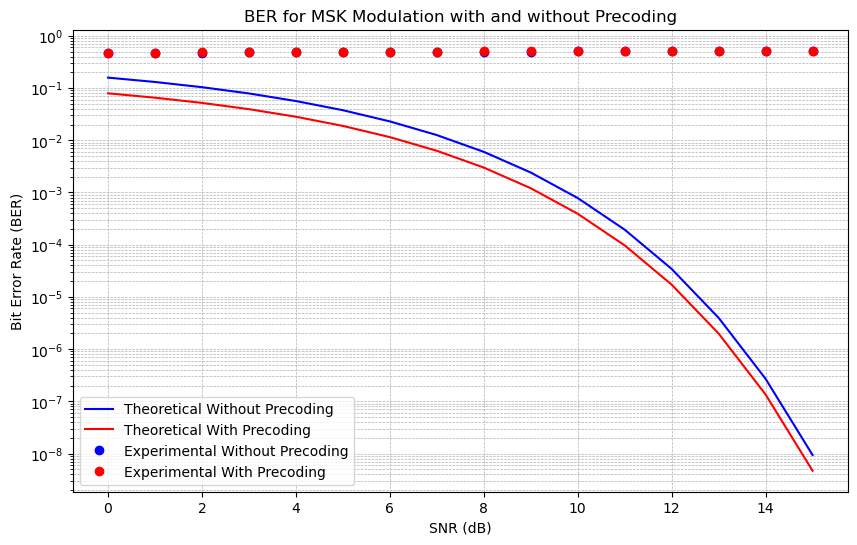

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import csv

def msk_ber_theoretical(snr_db):
    """Calculate the theoretical BER for MSK modulation without precoding."""
    snr_linear = 10**(snr_db / 10.0)
    ber = 0.5 * erfc(np.sqrt(snr_linear / 2))
    return ber

def msk_ber_theoretical_with_precoding(snr_db):
    """Calculate the theoretical BER for MSK modulation with precoding."""
    snr_linear = 10**(snr_db / 10.0)
    ber = 0.5 * erfc(np.sqrt(snr_linear / 2)) / 2  # Assuming precoding halves the BER
    return ber

def msk_modulate(bits, nsamp):
    """Modulate a bit sequence using MSK."""
    n = len(bits)
    g = np.ones(nsamp)
    xx = np.convolve(np.repeat(bits, nsamp), g)[:n * nsamp]
    theta = np.cumsum(xx) * np.pi / 2 / nsamp
    i_component = np.cos(theta)
    q_component = np.sin(theta)
    return i_component, q_component

def msk_demodulate(received_signal, fc, ts, nsamp):
    """Demodulate an MSK signal."""
    i_component = received_signal * np.cos(2 * np.pi * fc * ts) * 2
    q_component = -received_signal * np.sin(2 * np.pi * fc * ts) * 2

    f1 = 0.75 / nsamp
    order = 4 * nsamp
    b = signal.firwin(order + 1, f1 * 2)

    i_component = signal.lfilter(b, 1, np.concatenate((i_component, np.zeros(order))))[order // 2: len(i_component) + order // 2]
    q_component = signal.lfilter(b, 1, np.concatenate((q_component, np.zeros(order))))[order // 2: len(q_component) + order // 2]

    return i_component, q_component

def calculate_ber(original_bits, recovered_bits):
    """Calculate the bit error rate (BER)."""
    errors = np.sum(original_bits != recovered_bits)
    ber = errors / len(original_bits)
    return ber

def msk_simulation(Nbits, nsamp, EbNo, precoding=False):
    np.random.seed(0)  # For reproducibility
    R = 2000000
    fc = 8000000
    T = 1 / R
    Ts = T / nsamp

    # Generate random bit sequence
    bits = np.concatenate(([1], np.sign(np.random.rand(Nbits - 1) - 0.5)))

    # Apply precoding if necessary
    if precoding:
        bits = np.array([bits[0]] + [bits[i] * bits[i - 1] for i in range(1, len(bits))])

    # MSK modulation
    i_component, q_component = msk_modulate(bits, nsamp)
    ts = np.arange(0, len(i_component)) * Ts
    s = i_component * np.cos(2 * np.pi * fc * ts) - q_component * np.sin(2 * np.pi * fc * ts)

    # Add noise
    SNR_linear = 10 ** (EbNo / 10)
    noise_power = 1 / (2 * SNR_linear)
    noise = np.sqrt(noise_power) * np.random.normal(size=s.shape)
    received_signal = s + noise

    # MSK demodulation
    i_component, q_component = msk_demodulate(received_signal, fc, ts, nsamp)

    # Recover bits
    recovered_bits = np.zeros(Nbits)
    bi = 1
    for k in range(1, Nbits - 1, 2):
        li = np.arange(k * nsamp, (k + 2) * nsamp)
        lq = np.arange((k - 1) * nsamp, (k + 1) * nsamp)
        if li[-1] >= len(i_component) or lq[-1] >= len(q_component):
            break
        xi = i_component[li]
        xq = q_component[lq]
        gmi = np.cos(np.pi / 2 / T * Ts * li)
        gmq = -gmi
        bi_1 = bi
        bi = np.sign(np.sum(xi * gmi))
        bq = np.sign(np.sum(xq * gmq))

        recovered_bits[k] = bi_1 * bq
        recovered_bits[k + 1] = bi * bq

    # Return the BER calculation
    ber = calculate_ber(bits, recovered_bits)
    return ber

# Define the SNR range in dB
snr_db = np.arange(0, 16, 1)
Nbits = 10000
nsamp = 10

# Calculate theoretical BER for each SNR value
ber_theoretical = msk_ber_theoretical(snr_db)
ber_theoretical_with_precoding = msk_ber_theoretical_with_precoding(snr_db)

# Calculate experimental BER for each SNR value without and with precoding
ber_experimental_without_precoding = np.zeros_like(snr_db, dtype=float)
ber_experimental_with_precoding = np.zeros_like(snr_db, dtype=float)
for i, snr in enumerate(snr_db):
    ber_experimental_without_precoding[i] = msk_simulation(Nbits, nsamp, snr, precoding=False)
    ber_experimental_with_precoding[i] = msk_simulation(Nbits, nsamp, snr, precoding=True)

# Save the experimental values to a CSV file
with open('ber_experimental_values.csv', 'w', newline='') as csvfile:
    fieldnames = ['SNR (dB)', 'BER Without Precoding', 'BER With Precoding']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i, snr in enumerate(snr_db):
        writer.writerow({'SNR (dB)': snr, 'BER Without Precoding': ber_experimental_without_precoding[i], 'BER With Precoding': ber_experimental_with_precoding[i]})

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db, ber_theoretical, 'b-', label='Theoretical Without Precoding')
plt.semilogy(snr_db, ber_theoretical_with_precoding, 'r-', label='Theoretical With Precoding')
plt.semilogy(snr_db, ber_experimental_without_precoding, 'bo', label='Experimental Without Precoding')
plt.semilogy(snr_db, ber_experimental_with_precoding, 'ro', label='Experimental With Precoding')
plt.title('BER for MSK Modulation with and without Precoding')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


`````{dropdown} Code 6.3
````{tab} Python
```python
def msk_errors(Nbits, nsamp, EbNo):
    # Defined parameters
    n = Nbits  # number of data bits
    R = 270833  # bit rate
    fc = 3 * R  # carrier frequency
    ns = nsamp  # oversampling factor
    
    # AWGN channel
    SNR = EbNo - 10 * np.log10(ns / 2)  # in dB
    
    # Derived parameters
    T = 1 / R  # 1-bit period (= basic period)
    Ts = T / ns  # sampling frequency
    
    # Input sequence
    y = np.concatenate(([1], np.sign(np.random.rand(n - 1) - 0.5)))  # random numbers, -1 or 1
    
    # Precoding
    x = np.ones(n)
    for i in range(1, len(y)):
        x[i] = y[i] * y[i - 1]
    
    g = np.ones(ns)
    xx = upfirdn(g, x, up=ns)  # NRZ polar pulse train samples
    
    # Time grid
    ts = np.arange(0, len(xx) * Ts, Ts)  # of length ns*(n+1)
    
    ## MSK TRANSMITTER
    xs = xx
    theta = np.cumsum(xs) * np.pi / 2 / ns
    xs_i = np.cos(theta)  # in-phase component
    xs_i = np.append(xs_i, xs_i[-1])  # one-sample extension
    xs_q = np.sin(theta)  # quadrature component
    xs_q = np.append(xs_q, xs_q[-1])  # one-sample extension
    
    # Modulation
    s = xs_i * np.cos(2 * np.pi * fc * ts) - xs_q * np.sin(2 * np.pi * fc * ts)
    
    # Addition of noise
    s = awgn(s, SNR)
    
    ## MSK RECEIVER
    xs_i = s * np.cos(2 * np.pi * fc * ts)
    xs_q = -s * np.sin(2 * np.pi * fc * ts)
    
    # LP (Parks-McClellan) filter
    f1 = 0.75 / ns
    f2 = 4 * f1
    order = 4 * ns
    fpts = [0, f1, f2, 1]
    mag = [1, 1, 0, 0]
    wt = [1, 1]
    b = firwin(order + 1, [f1, f2], pass_zero=False, fs=1.0)
    a = 1
    
    len_xs_i = len(xs_i)
    dummy = np.concatenate((xs_i, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    delay = order // 2
    xs_i = dummy1[delay:delay + len_xs_i]
    
    dummy = np.concatenate((xs_q, np.zeros(order)))
    dummy1 = lfilter(b, a, dummy)
    xs_q = dummy1[delay:delay + len_xs_i]
    
    bi = 1
    xr_1 = 1
    xr = np.zeros(n)
    for k in range(0, n - 1, 2):
        li = np.arange(k * ns, (k + 2) * ns)
        lq = np.arange((k - 1) * ns, (k + 1) * ns)
        xi = xs_i[li]
        xq = xs_q[lq]
        gmi = np.cos(np.pi / 2 / T * Ts * li)  # matched-filter pulse
        gmq = -gmi  # =sin(pi/2/T*Ts*lq);
        bi_1 = bi
        bi = np.sign(np.sum(xi * gmi))
        bq = np.sign(np.sum(xq * gmq))
        # Without precoding: de-comment next 2 lines
        # xr[k] = bi_1 * bq
        # xr[k + 1] = bi * bq
        # With precoding: de-comment next 2 lines
        xr[k] = xr_1 * bi_1 * bq
        xr[k + 1] = xr[k] * bi * bq
        xr_1 = xr[k + 1]
    
    xr = xr.reshape(-1)
    err = np.not_equal(y, xr)  # de-comment, with pre-coding
    errors = np.sum(err)
    return errors
```
````
````{tab} Matlab
```matlab
function errors=msk_errors(Nbits,nsamp,EbNo)
% Defined parameters
n=Nbits; % number of data bits
R=270833; % bit rate
fc=3*R; % carrier frequency
ns=nsamp; % oversampling factor
%
% δίαυλος awgn
SNR=EbNo-10*log10(ns/2); % in db
% Derived parameters
T=1/R; % 1-bit period (= basic period)
Ts=T/ns; % sampling frequency
% input sequence
y=[1;sign(rand(n-1,1)-0.5)]; % random numbers, -1 or 1
%
% precoding
x(1)=1;
for i=2:length(y)
    x(i)=y(i)*y(i-1);
end
x=x';
g=ones(ns,1);
xx=conv(upsample(x,ns),g); % NRZ polar pulse train samples
% time grid
ts=[0:Ts:length(xx)*Ts]'; % of length ns*(n+1)
%
%% MSK TRANSMITTER
xs=xx;
theta=cumsum(xs)*pi/2/ns;
xs_i=cos(theta); % in-phase component
xs_i=[xs_i; xs_i(length(xs_i))]; % one-sample extension
xs_q=sin(theta); % quadrature component
xs_q=[xs_q; xs_q(length(xs_q))]; % one-sample extension
% Modulation
s=xs_i.*cos(2*pi*fc*ts)-xs_q.*sin(2*pi*fc*ts);
% addition of noise
s=awgn(s,SNR, 'measured');
%% MSK RECEIVER
xs_i=s.*cos(2*pi*fc*ts);
xs_q=-s.*sin(2*pi*fc*ts);
% LP (Parks-McClellan)filter
f1=0.75/ns; f2=4*f1;
order=4*ns;
fpts=[0 f1 f2 1];
mag=[1 1 0 0];
wt=[1 1];
b = firpm(order,fpts,mag,wt);
a=1;
len=length(xs_i);
dummy=[xs_i;zeros(order,1)];
dummy1=filter(b,a,dummy);
delay=order/2; % Try with delay=0!
xs_i=dummy1(delay+(1:len));
dummy=[xs_q;zeros(order,1)];
dummy1=filter(b,a,dummy);
delay=order/2;
xs_q=dummy1(delay+(1:len));
bi=1; xr_1=1;
for k=1:2:n-1
    li=(k*ns+1:(k+2)*ns)';
    lq=((k-1)*ns+1:(k+1)*ns)';
    xi=xs_i(li);
    xq=xs_q(lq);
    gmi=cos(pi/2/T*Ts*li); % matched-filter pulse
    gmq=-gmi; % =sin(pi/2/T*Ts*lq);
    bi_1=bi;
    bi=sign(sum(xi.*gmi));
    bq=sign(sum(xq.*gmq));
    % without precoding: de-comment next 2 lines
    % xr(k)=bi_1*bq;
    % xr(k+1)=bi*bq;
    % with precoding: de-comment next 2 lines
    xr(k)=xr_1*bi_1*bq;
    xr(k+1)=xr(k)*bi*bq;
    xr_1=xr(k+1);
end
xr=xr';
% err=not(x==xr);
err=not(y==xr); % de-comment, with pre-coding
errors=sum(err);
end
```
````
`````

### Step 2:

For the data of the previous question, find the values of the parameters of an
equivalent (in terms of bit rate) QPSK system. Compare the two systems in
terms of BER and bandwidth.

```{tip}
According to the figure below, for each odd k, the new bi (valid from the
next even k) and bq are calculated. Based on these, the two new bits are calculated,
xr(k)=bi_1*bq and xr(k+1)=bi*bq. With precoding, bit xr_1 of the previous period (k-1) is
also used.
```

![lab6_1.png](../content/images/lab6_1.png)
